# Compute and visualize dependency maps

This notebok shows you how to compute dependency maps for different DNA LMs and visualize them for your specific sequences.

In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt

## SpeciesLM Fungi

In [2]:
from datasets import Dataset
from transformers import BertForMaskedLM, AutoTokenizer, DefaultDataCollator

# Load the model
model_name = "johahi/specieslm-fungi-upstream-k1"
model = BertForMaskedLM.from_pretrained(model_name, trust_remote_code=True) 

# Load the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#this is the huggingface version of the model. It is considerably slower than the flash version, but it is easier to use. 
#If you want to use the flash version, you can download the model from the linked zenodo repository and load it with the following code:

'''
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import BertConfig
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from flash_attn.models.bert import BertModel, BertForPreTraining

model_path = 'species_upstream_1000_k1/'

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path)
model = BertForPreTraining.from_pretrained(model_path, config)
'''

/home/kchao10/miniconda3/envs/pytorch_cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 21:29:39.198889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 21:29:39.241953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-03 21:29:39.241996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-0

"\nfrom datasets import Dataset\nfrom transformers import AutoTokenizer\nfrom transformers import BertConfig\nfrom transformers import AutoModelForSequenceClassification, DefaultDataCollator\nfrom flash_attn.models.bert import BertModel, BertForPreTraining\n\nmodel_path = 'species_upstream_1000_k1/'\n\ntokenizer = AutoTokenizer.from_pretrained(model_path)\nconfig = BertConfig.from_pretrained(model_path)\nmodel = BertForPreTraining.from_pretrained(model_path, config)\n"

In [3]:
device = "cuda"
model.to(device)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(1408, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [4]:
print(f'GPU Model: {torch.cuda.get_device_name(0)}')

GPU Model: NVIDIA A100-PCIE-40GB


In [5]:
## Visualization functions

import seaborn as sns
import matplotlib.pyplot as plt

def plot_map_with_seq(matrix, dna_sequence,  plot_size=10, vmax=5, tick_label_fontsize=8):

    fig, ax = plt.subplots(figsize=(plot_size, plot_size))
    
   
    sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, ax=ax, 
                xticklabels=False, yticklabels=False)  
    ax.set_aspect('equal')

    tick_positions = np.arange(len(dna_sequence)) + 0.5 # Center the ticks

    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(list(dna_sequence), fontsize=tick_label_fontsize, rotation=0)
    ax.set_yticklabels(list(dna_sequence), fontsize=tick_label_fontsize)

    plt.show()
    
def plot_map(matrix, vmax=None, display_values=False, annot_size=8, fig_size=10):
   
    plt.figure(figsize=(fig_size, fig_size))

    ax = sns.heatmap(matrix, cmap="coolwarm", vmax=vmax, annot=display_values, 
                     fmt=".2f", annot_kws={"size": annot_size})

    ax.set_aspect('equal')

    plt.show()

In [6]:
#dependency map generation functions

nuc_table = {"A" : 0, "C":1, "G":2, "T":3}

def mutate_sequence(seq):
    
    seq = seq.upper()
    mutated_sequences = {'seq':[], 'mutation_pos':[], 'nuc':[], 'var_nt_idx':[]}
    mutated_sequences['seq'].append(seq)
    mutated_sequences['mutation_pos'].append(-1)
    mutated_sequences['nuc'].append('real sequence')
    mutated_sequences['var_nt_idx'].append(-1)


    mutate_until_position = len(seq)

    for i in range(mutate_until_position):
        for nuc in ['A', 'C', 'G', 'T']:
            if nuc != seq[i]:
                mutated_sequences['seq'].append(seq[:i] + nuc + seq[i+1:])
                mutated_sequences['mutation_pos'].append(i)
                mutated_sequences['nuc'].append(nuc)
                mutated_sequences['var_nt_idx'].append(nuc_table[nuc])

    mutations_df = pd.DataFrame(mutated_sequences)

    return mutations_df

def tok_func_species(x, proxy_species):
    
    res = tokenizer(proxy_species + " ".join(list(x['seq'])))

    return res


def create_dataloader(dataset, proxy_species, batch_size=64, rolling_masking=False):

    ds = Dataset.from_pandas(dataset[['seq']]) 
    tok_ds = ds.map(lambda x: tok_func_species(x, proxy_species=proxy_species), batched=False,  num_proc=20)
    rem_tok_ds = tok_ds.remove_columns('seq')

    data_collator = DefaultDataCollator()

    data_loader = torch.utils.data.DataLoader(rem_tok_ds, batch_size=batch_size, num_workers = 4, shuffle = False, collate_fn=data_collator)

    return data_loader

acgt_idxs = [tokenizer.get_vocab()[nuc] for nuc in ['A', 'C', 'G', 'T']]

def model_inference(model, data_loader):

    output_arrays = []
    for i, batch in enumerate(data_loader):
        print(f"Batch {i+1}/{len(data_loader)}")
        # get some tokenized sequences (B, L_in)
        tokens = batch['input_ids']
        # predict
        with torch.autocast(device):
            with torch.no_grad():
                outputs = model(tokens.to(device)).logits.cpu().to(torch.float32)
        output_probs = torch.nn.functional.softmax(outputs, dim=-1)[:,:,acgt_idxs] # B, L_seq, 4
        output_arrays.append(output_probs) 

    # rebuild to B, L_seq, 4
    snp_reconstruct = torch.concat(output_arrays, axis=0)

    return snp_reconstruct.to(torch.float32).numpy()

def compute_dependency_map(seq, proxy_species, epsilon=1e-10):

    dataset = mutate_sequence(seq) 
    data_loader = create_dataloader(dataset, proxy_species=proxy_species)
    snp_reconstruct = model_inference(model, data_loader)
    print("snp_reconstruct: ", snp_reconstruct.shape)
    snp_reconstruct = snp_reconstruct[:,2:-1,:] # discard the beginning of sentence token, species token and end of sentence token

     # for the logit add a small value epsilon and renormalize such that every prob in one position sums to 1
    snp_reconstruct = snp_reconstruct + epsilon
    snp_reconstruct = snp_reconstruct/snp_reconstruct.sum(axis=-1)[:,:, np.newaxis]

    seq_len = snp_reconstruct.shape[1]
    snp_effect = np.zeros((seq_len, seq_len,4, 4))
    reference_probs = snp_reconstruct[dataset[dataset['nuc'] == 'real sequence'].index[0]]
    snp_reconstruct_return = reference_probs.copy()
    
    snp_effect[dataset.iloc[1:]['mutation_pos'].values, : ,  dataset.iloc[1:]['var_nt_idx'].values,:] = np.log2(snp_reconstruct[1:]) - np.log2(1 - snp_reconstruct[1:]) \
        - np.log2(reference_probs) + np.log2(1-reference_probs)

    dep_map = np.max(np.abs(snp_effect), axis=(2,3))
    #zero main diagonal values
    dep_map[np.arange(dep_map.shape[0]), np.arange(dep_map.shape[0])] = 0

    return dep_map, snp_reconstruct_return

In [7]:
proxy_species = 'kazachstania_africana_cbs_2517_gca_000304475'

In [8]:
#sequence 1kb 5' of the start codon of SMT3 in S. cerevisiae
SMT3_five_prime_seq = 'GCTTCCCTCATTATTCCGCCCATGGCGTCTATTACCAAGCGTCATAATGTGCAATATTTGATATTATATAAGCTACTTGAGAAAGCGATAGTTTTTTTTTCTTACACAAAAAAAAAAAAACATAAAGCACCTATAACTCTCAACTTTGAAGAAGCACGAAAGGAATATGTTTAAATCAACAGAAATGTGAAAAAAATCGGTTATATATACAGAATCCGATTCTTTCTAACATCAAAGAGGTGGGGGAAGAAGGGACTCAAAAAAGAAACGACACTGCACAACCCGAGCCAAACTGACATACGAACACTAAAACCGATTTCCGAAAAAAACTTCAAATTTACATTTCATTGTCCGTCTGCCATCGCATCATCGCCTTCATCTCTAAGAGTTGCCGTGCCTTTCCATCCGCTTTCTTTTCATGCGGCGTTATTCTTTTTTCCTATTTTTGATGGTCCCTGTGCCGTTTCTTTTTCATGTTCACCGGTTTTTGGCGCCGCATACCGTACGGCGGGGCACTTTTGAAACGTTTTTGTGCATCCTGATGCCGTTTTCAAGGATCGCAAGCACGTCGCATAATACGGTAATGCCGAATTAAGGCTACGTCGTCATAGTAGGTTAGTCATGCGCGTTGGAAAAAGAAATGACCAACGCGTTGATTACGTAGTCCCCAAGGAATAATGCTTTTGAAAGTGAAAAAAAAAAATAAAACTGAAAAAAGCCATGCTGTTTCCATCACGTGCATGTCACGTTTTTGCCGCCGAACTCTTTGATCATGTGATATGAATATGTTGGGTTACCCAGCTTTGCCAACACGCGCCGTCGGAAGGTGTTCAGGAAGCAGGAAAAGAGCAAAACACCAACAATCAAACAAACGAACACATTCTACTCTTTTAGTTGATTTTTCTTACCTTTTCCAAGCTCCCGTTTCTTGTTACCACCTGTAGCATATAGGACAGAAGGACCCAGTTCAGTTCTAGTTTTACAAATAAATACACGAGCGATG'

Computing the full 1kb dependency map should take about 12s with the flash version of the model on an NVIDIA A40 GPU.

In [9]:
dep_map, all_prbs = compute_dependency_map(SMT3_five_prime_seq,proxy_species=proxy_species)

Map (num_proc=20): 100%|██████████| 3010/3010 [00:00<00:00, 3769.38 examples/s]


Batch 1/48
Batch 2/48
Batch 3/48
Batch 4/48
Batch 5/48
Batch 6/48
Batch 7/48
Batch 8/48
Batch 9/48
Batch 10/48
Batch 11/48
Batch 12/48
Batch 13/48
Batch 14/48
Batch 15/48
Batch 16/48
Batch 17/48
Batch 18/48
Batch 19/48
Batch 20/48
Batch 21/48
Batch 22/48
Batch 23/48
Batch 24/48
Batch 25/48
Batch 26/48
Batch 27/48
Batch 28/48
Batch 29/48
Batch 30/48
Batch 31/48
Batch 32/48
Batch 33/48
Batch 34/48
Batch 35/48
Batch 36/48
Batch 37/48
Batch 38/48
Batch 39/48
Batch 40/48
Batch 41/48
Batch 42/48
Batch 43/48
Batch 44/48
Batch 45/48
Batch 46/48
Batch 47/48
Batch 48/48
snp_reconstruct:  (3010, 1006, 4)


In [10]:
print("length of sequence: ", len(SMT3_five_prime_seq))
print(dep_map.shape)
print(all_prbs.shape)

length of sequence:  1003
(1003, 1003)
(1003, 4)


In [11]:
# I want to save all_prbs into a file
np.save('all_prbs.npy', all_prbs)

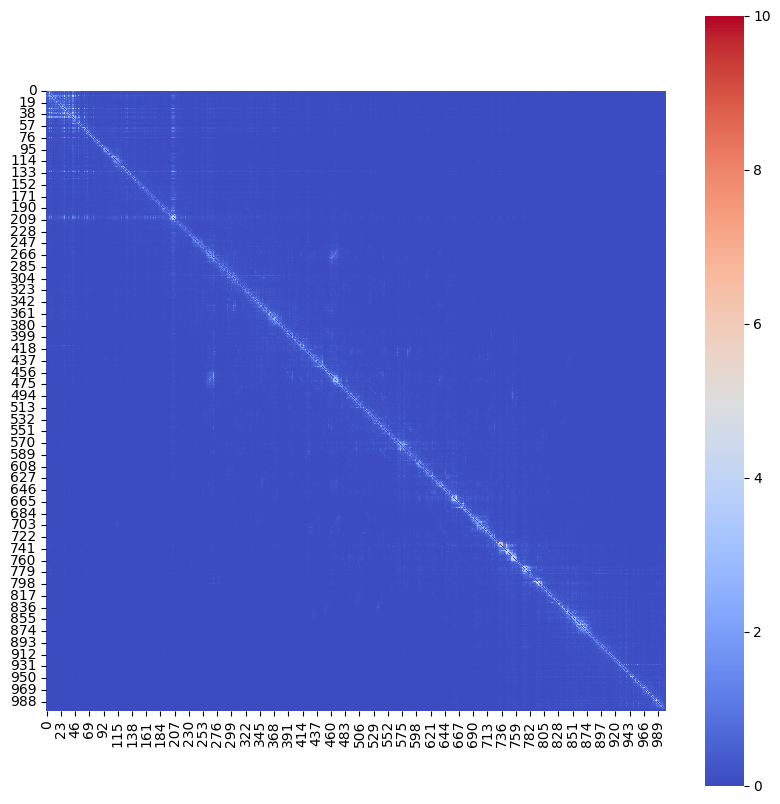

In [13]:
plot_map(dep_map, vmax=10)

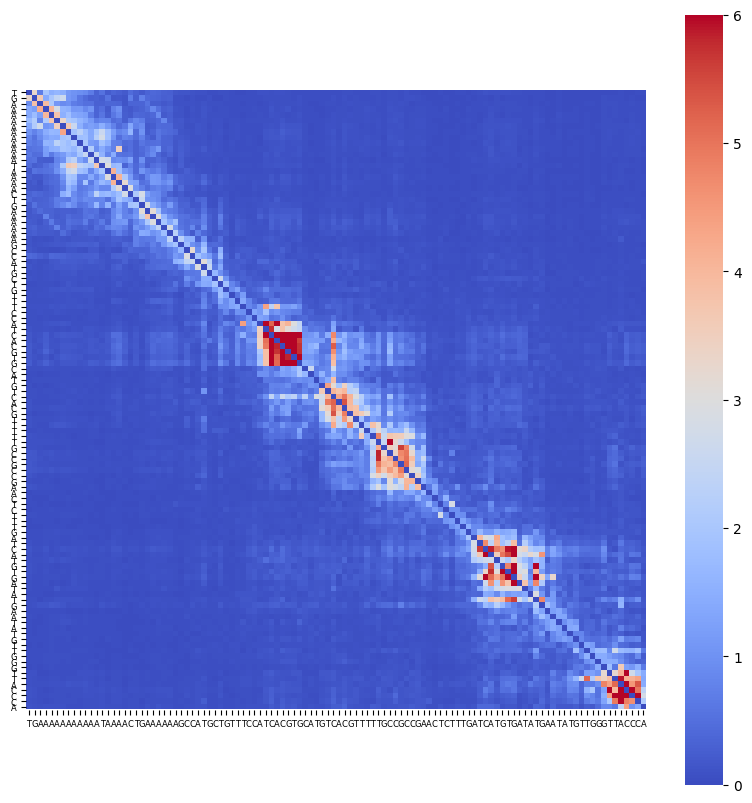

In [14]:
#SMT3 promoter in S cerevisiae
plot_map_with_seq(dep_map[690:800,690:800],  SMT3_five_prime_seq[690:800], vmax=6, tick_label_fontsize=6)

In [17]:
from utils import plot_weights

In [34]:
def compute_log_ratio(nuc_probs):
    nucs_mean = nuc_probs[:-3].mean(axis = 0)
    nucs_normed = nuc_probs * np.log2(nuc_probs/nucs_mean)
    return nucs_normed
def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.325, 0.176, 0.175, 0.324]), #background nucleotide frequency in S cerevisiae
                            pseudocount=0):
    ppm=ppm.unsqueeze(0)
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

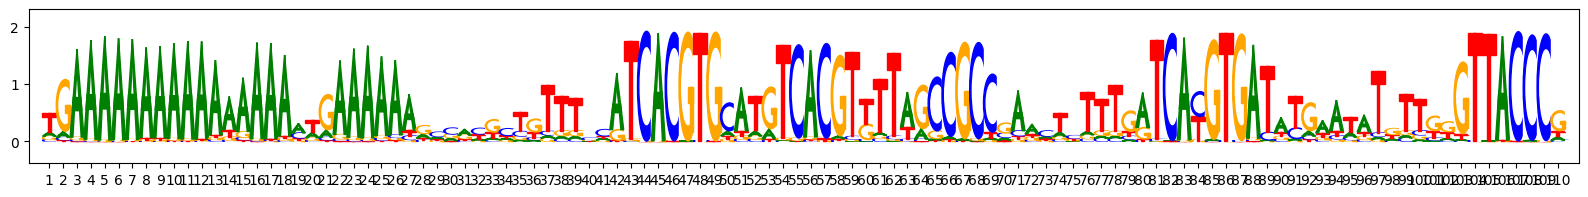

In [35]:
import torch

# Convert your numpy array to a torch tensor
all_prbs_tensor = torch.from_numpy(all_prbs).float()  # Ensure it's a float tensor

# Now use the tensor with your function
result = all_prbs_tensor * compute_per_position_ic(all_prbs_tensor).swapaxes(0, 1)

# Convert the result back to numpy if needed for plotting
plot_weights(result.numpy()[690:800], subticks_frequency=1)

In [19]:
#First download the RiNALMO files and code from their github at https://github.com/lbcb-sci/RiNALMo